# Solving a different problem: uncertainty-constrained temperature maximization

## Temperature as the objective

It would be nice to avoid solving a nonconvex QCQP with a shell constraint. What if, instead of minimizing wind deviations, we fixed a wind forecast inaccuracy limit (placing bounds on deviation variables) and maximized heat input to each line? This would give us a set of wind patterns, each one based on $x\%$ maximum forecast inaccuracy, that would maximally heat one line in the network. We could then filter that list based on which line temperatures are greatest, and sort remaining patterns according to distance from the forecast. In the end, we would have the most likely wind pattern (assuming inaccuracy of $x\%$) guaranteed to saturate a line.

We get a quadratic program like this:

\begin{align}
&& z_{ik}^* = \max~ & z^\top Q_{\theta} z \\
s.t. && Az &= b \\
&& x &\leq c\cdot P0  \\
&& x &\geq -c\cdot P0
\end{align}

where $z$ is the vector of all variables, $x$ contains only wind deviation variables, and $P0$ is the vector of wind forecast values. We define $A$ to ensure the right line $(i,k)$ is chosen, and we repeat the optimization to find $z_{ik}^*$ for every line in the network. This gives us a set of system states (including wind deviations), each of which reflects maximal heating of one line in the network subject to the given forecast inaccuracy.

One nice side-effect of this formulation is that we don't have to worry about wind farm output going negative. Deviations are bounded, so they cannot exceed forecast values as long as $c\leq 1$.

## Understanding the output

Now suppose $z_{ik}^*$ results in a temperature of $T_{ik}^*$ for line $(i,k)$, and the line's maximum allowable temperature is $T_{ik}^{max}$. If $T_{ik}^* \geq T_{ik}^{max}$, we have a problem. Otherwise, there is no wind pattern within the forecast inaccuracy limits that will excessively heat line $(i,k)$. We remove $z_{ik}^*$ from our list and move on.

In the end we have a set of problematic system states. If this set is empty, we need to increase the inaccuracy limit and re-do the optimization. Otherwise, we rank members of the set according to $\lVert x_{ik}^*\rVert$, the normed distance between the forecast and the actual wind pattern. This gives us a set of "extreme events" sorted roughly by likelihood (since patterns closer to the forecast are more likely to occur).

## Reusing existing code

There isn't time to solve this new problem from scratch, but I can reuse many elements of code I have already written.

* $Q_\theta$ selects only the $\hat{\theta}_{ik}$ variables from $z$. This is the same function it has in the original problem, so the code doesn't need alteration.

* $Ax=b$ ensures power balance and implements distributed slack. It also defines $\hat{\theta}_{ik}$ appropriately. I do not need to change this at all.

* All I need to do is add constraints to limit wind deviations (otherwise, the objective could increase without bound).

## Building and solving a model

In [1]:
####### IMPORTS: INSTANTON CODE ########
# Get instanton code into workspace:
include("../src/maxTemp.jl")
using maxTemp

In [2]:
####### IMPORTS: DATA ACQUISITION ########
include("../src/tmp_inst_rts96.jl")

psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

ref = 1 # Index of ref node
tau = 1.5 # Heating constant
c = 0.2 # Forecast inaccuracy limit

Ridx = find(Rp) # Vector of renewable nodes
G0 = [Gp,Gp.*0.95,Gp.*0.9]
D0 = [Dp,Dp.*0.95,Dp.*0.9]
P0 = [Rp,Rp.*1.1,Rp]
Y = full(Y) # Full admittance matrix (ref not removed)

lines = [(f[i],t[i]) for i in 1:length(f)];

In [3]:
score,result,x,θ,α,diffs = maxTempInstanton(Ridx,Y,ref,G0,P0,D0,k,tau,lines[1:2],0.5)

([2.2932e-5,0.0453835],[:Optimal,:Optimal],Array[[[-0.0410327,-0.0224674,0.242398,0.409692,0.076281,0.160209,0.105814,0.268494,-0.0399621,-0.179177,-0.0211847,-0.0352812,-0.00937566,-0.0837322,-0.139395,0.152004,0.141108,0.00729019],[-0.0451359,-0.0245884,0.266635,0.450659,0.0839071,0.176226,0.116384,0.295341,-0.043373,-0.197087,-0.023292,-0.0387971,-0.0103058,-0.0920856,-0.153308,0.1672,0.155215,0.00801549],[-0.0410325,-0.0208662,0.24239,0.409685,0.0762742,0.160195,0.105772,0.268487,-0.036475,-0.179151,-0.0211485,-0.0352407,-0.00935098,-0.0836665,-0.139308,0.151991,0.141095,0.00727812]],[[-0.0410329,0.022521,0.242403,0.409697,0.0762857,0.160219,0.105844,0.268498,0.0402597,0.179194,0.0212114,0.0353101,0.00940641,0.0837786,0.139456,0.152013,0.141117,0.00729893],[-0.0451361,0.0247731,0.266644,0.450667,0.0839143,0.176241,0.116428,0.295348,0.0442857,0.197113,0.0233324,0.038841,0.010347,0.0921565,0.153402,0.167214,0.155229,0.00802882],[-0.0410329,0.0225209,0.242403,0.409697,0.0762857,0.1602

In [4]:
using Reactive, Interact
using PyPlot

INFO: Loading help data...


In [26]:
c = slider(0.05:0.01:0.5, label="c")

Slider{Float64}([Input{Float64}] 0.27,"c",0.27,0.05:0.01:0.5)

In [52]:
stuff = lift(c -> maxTempInstanton(Ridx,Y,ref,G0,P0,D0,k,tau,[lines[1:5]],c)[end][1],signal(c))

3-element Array{Float64,1}:
 0.00201207
 0.00192165
 0.00183123

Slider{Float64}([Input{Float64}] 1.4,"τ",1.4,0.8:0.1:2.0)

Slider{Float64}([Input{Float64}] 1.0,"Rscale",1.0,0.7:0.1:1.3)

Slider{Int64}([Input{Int64}] 60,"Lidx",60,1:120)

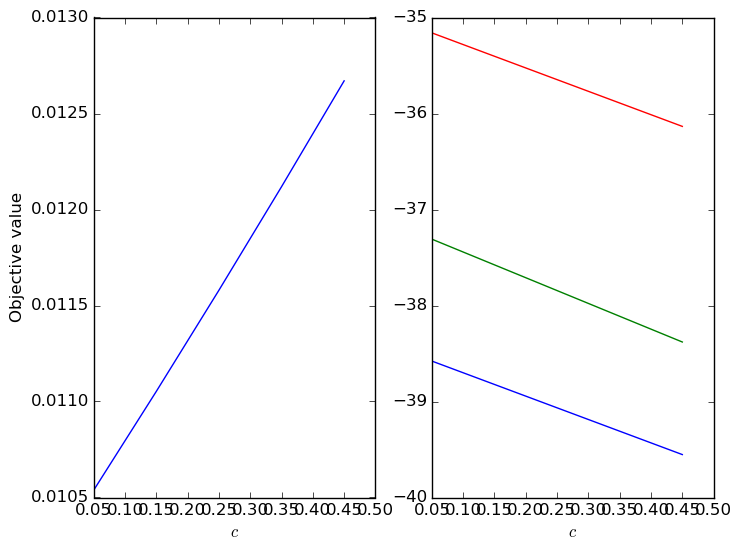

In [35]:
cvals = 0.05:0.1:0.5
f = figure();
@manipulate for τ = 0.8:0.1:2, Rscale = 0.7:0.1:1.3, Lidx = 1:120; withfig(f) do
        subplot(121)
        plot(cvals,[maxTempInstanton(Ridx,Y,ref,Rscale.*G0,P0,D0,k,τ,lines[Lidx:Lidx],i)[1] for i in cvals])
        xlabel(L"c")
        ylabel("Objective value")
        subplot(122)
        plot(cvals,[maxTempInstanton(Ridx,Y,ref,Rscale.*G0,P0,D0,k,τ,lines[Lidx:Lidx],i)[5][1] for i in cvals])
        xlabel(L"c")
        # ylabel("Angle differences")
end
end

In [30]:
lines[42]

(25,26)

## Next step: getting fully convinced

The output looks clean -- perhaps too clean. As $c$ is increased, angle differences increase linearly and objective values increase quadratically. Optimization takes 5.6 seconds for all lines even though this is a nonconvex problem. 

So far I have checked several things:

* $Ax=b$ is satisfied by the solutions I've checked.

* Mismatch values pass a sanity check.

* Results make sense qualitatively.

I need to visualize the output to be fully confident in these numbers. Fortunately I have more code that may be reused for this purpose.